In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import mstats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('new_isc_04.csv')

In [ ]:
def winsorize_data(df, columns, limits=[0.05, 0.05]):
    for column in columns:
        df[column] = mstats.winsorize(df[column], limits=limits)
    return df

In [ ]:
id_column = 'id'
df = df.drop(id_column, axis=1)

In [ ]:
print(df['remaining_contract'].isnull().sum())
print(df['remaining_contract'].isnull().sum() / len(df) * 100)

18524
29.745961396409413


In [ ]:
print(df[df['remaining_contract'].isnull()]['churn'].value_counts(normalize=True))
print(df[df['remaining_contract'].notnull()]['churn'].value_counts(normalize=True))

churn
1    0.913518
0    0.086482
Name: proportion, dtype: float64
churn
0    0.598194
1    0.401806
Name: proportion, dtype: float64


In [ ]:
target = 'churn'

In [ ]:
bin_features = ['is_tv_subscriber', 'is_movie_package_subscriber']
non_bin_features = df.columns.drop(bin_features + [target])

In [ ]:
features_for_imputation = ['id', 'subscription_age', 'is_tv_subscriber', 'is_movie_package_subscriber',
                           'bill_avg', 'service_failure_count', 'download_avg', 'upload_avg', 'download_over_limit', 'remaining_contract']

Imputacja brakujących wartości w pliku wyjściowym.

In [ ]:
def evaluate_imputation(estimator, n_estimators=None):
    if n_estimators:
        imp = IterativeImputer(estimator=estimator(n_estimators=n_estimators), max_iter=10, random_state=42)
    else:
        imp = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42)

        df[features_for_imputation] = imp.fit_transform(df[features_for_imputation])
    return df

In [ ]:
df_imputed = evaluate_imputation(RandomForestRegressor, n_estimators=100)

In [ ]:
X = df_imputed.drop(columns=[target])
y = df_imputed[target]

In [ ]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
missing_values = np.isnan(X_train).sum()
print("Missing values in training set:\n", missing_values)

missing_values_test = np.isnan(X_test).sum()
print("Missing values in test set:\n", missing_values_test)

Missing values in training set:
 is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
remaining_contract             14882
service_failure_count              0
download_avg                     261
upload_avg                       261
download_over_limit                0
dtype: int64
Missing values in test set:
 is_tv_subscriber                  0
is_movie_package_subscriber       0
subscription_age                  0
bill_avg                          0
remaining_contract             3642
service_failure_count             0
download_avg                     70
upload_avg                       70
download_over_limit               0
dtype: int64


Ponowna imputacja w celu usunięcia pozostałych brakujących wartości.

In [ ]:
imp_mean = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imp_mean.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imp_mean.transform(X_test), columns=X_test.columns)

In [ ]:
missing_values = np.isnan(X_train_imputed).sum()
print("Missing values in training set:\n", missing_values)

missing_values_test = np.isnan(X_test_imputed).sum()
print("Missing values in test set:\n", missing_values_test)

Missing values in training set:
 is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
remaining_contract             0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
dtype: int64
Missing values in test set:
 is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
remaining_contract             0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
dtype: int64


In [ ]:
scaler = StandardScaler()
X_train_imputed = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Dalsze czyszczenie setu treningowego i testowego. Mimo imputacji pojawiał się przy regresji liniowej, logistycznej i SVM błąd NaN.

In [ ]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data_clean = train_data.dropna()

X_train_clean = train_data_clean.drop(columns=[target])
y_train_clean = train_data_clean[target]

test_data = pd.concat([X_test, y_test], axis=1)
test_data_clean = test_data.dropna()
X_test_clean = test_data_clean.drop(columns=[target])
y_test_clean = test_data_clean[target]

In [ ]:
scaler = StandardScaler()
X_train_clean_imputed = pd.DataFrame(scaler.fit_transform(X_train_clean), columns=X_train_clean.columns)
X_test_clean_imputed = pd.DataFrame(scaler.transform(X_test_clean), columns=X_test_clean.columns)

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train_clean_imputed, y_train_clean)

y_pred_lr = lr_model.predict(X_test_clean_imputed)
y_pred_lr_binary = (y_pred_lr > 0.5).astype(int)

accuracy = accuracy_score(y_test_clean, y_pred_lr_binary)
precision = precision_score(y_test_clean, y_pred_lr_binary)
recall = recall_score(y_test_clean, y_pred_lr_binary)
f1 = f1_score(y_test_clean, y_pred_lr_binary)

print(f"Model accuracy after imputation: {accuracy}")
print(f"Model precision after imputation: {precision}")
print(f"Model recall after imputation: {recall}")
print(f"Model F1 score after imputation: {f1}")
print(f"Training set size: {X_train_clean_imputed.shape[0]}")
print(f"Test set size: {X_test_clean_imputed.shape[0]}")

Model accuracy after imputation: 0.8592964824120602
Model precision after imputation: 0.8105703819989535
Model recall after imputation: 0.8591236827509706
Model F1 score after imputation: 0.8341410877759828
Training set size: 34713
Test set size: 8756


In [ ]:
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_clean_imputed, y_train_clean)

y_pred_log = log_model.predict(X_test_clean_imputed)
y_pred_log_binary = (y_pred_log > 0.5).astype(int)

accuracy = accuracy_score(y_test_clean, y_pred_log_binary)
precision = precision_score(y_test_clean, y_pred_log_binary)
recall = recall_score(y_test_clean, y_pred_log_binary)
f1 = f1_score(y_test_clean, y_pred_log_binary)

print(f"Model accuracy after imputation: {accuracy}")
print(f"Model precision after imputation: {precision}")
print(f"Model recall after imputation: {recall}")
print(f"Model F1 score after imputation: {f1}")
print(f"Training set size: {X_train_clean_imputed.shape[0]}")
print(f"Test set size: {X_test_clean_imputed.shape[0]}")

Model accuracy after imputation: 0.8704888076747374
Model precision after imputation: 0.8408714837286266
Model recall after imputation: 0.8455352190793123
Model F1 score after imputation: 0.8431969026548674
Training set size: 34713
Test set size: 8756


In [ ]:
svm_model = SVC(random_state=42)
svm_model.fit(X_train_clean_imputed, y_train_clean)

y_pred_svm = svm_model.predict(X_test_clean_imputed)
y_pred_svm_binary = (y_pred_svm > 0.5).astype(int)

accuracy = accuracy_score(y_test_clean, y_pred_svm_binary)
precision = precision_score(y_test_clean, y_pred_svm_binary)
recall = recall_score(y_test_clean, y_pred_svm_binary)
f1 = f1_score(y_test_clean, y_pred_svm_binary)

print(f"Model accuracy after imputation: {accuracy}")
print(f"Model precision after imputation: {precision}")
print(f"Model recall after imputation: {recall}")
print(f"Model F1 score after imputation: {f1}")
print(f"Training set size: {X_train_clean_imputed.shape[0]}")
print(f"Test set size: {X_test_clean_imputed.shape[0]}")

Model accuracy after imputation: 0.9050936500685245
Model precision after imputation: 0.9048730668222935
Model recall after imputation: 0.8599556295063783
Model F1 score after imputation: 0.8818427413621499
Training set size: 34713
Test set size: 8756


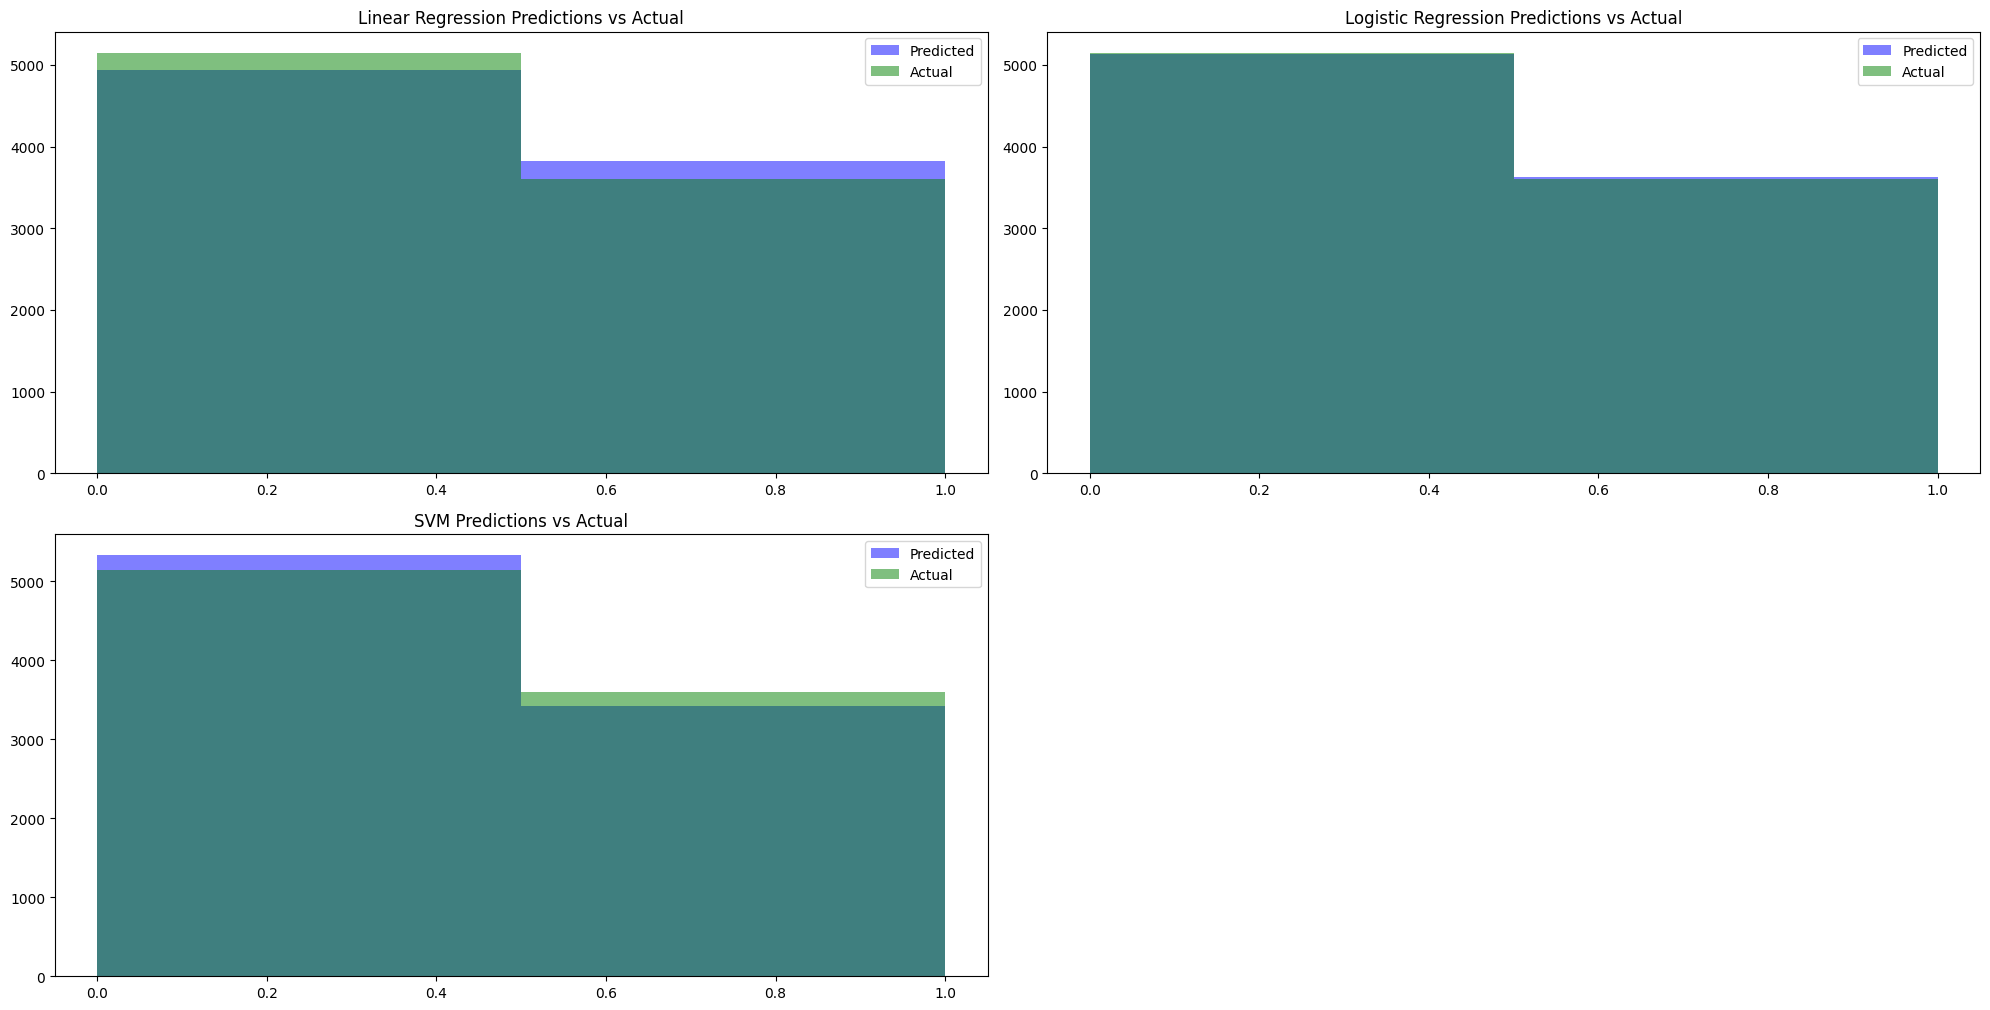

Best model: SVM


In [ ]:
models = [lr_model, log_model, svm_model]
model_names = ['Linear Regression', 'Logistic Regression','SVM']

results = {}


plt.figure(figsize=(20, 15))

for i, (model, name) in enumerate(zip(models, model_names), 1):
    if name in ['Linear Regression', 'Logistic Regression', 'SVM']:
        X = X_test_clean_imputed
        y_true = y_test_clean
    else:
        X = X_test_imputed
        y_true = y_test

    y_pred = model.predict(X)
    if name == 'Linear Regression':
        y_pred = (y_pred > 0.5).astype(int)

    plt.subplot(3, 2, i)
    plt.hist(y_pred, bins=2, alpha=0.5, label='Predicted', color='blue')
    plt.hist(y_true, bins=2, alpha=0.5, label='Actual', color='green')
    plt.title(f'{name} Predictions vs Actual')
    plt.legend()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

plt.tight_layout()
plt.show()

best_model = max(results, key=lambda x: results[x]['accuracy'])
best_model = max(results, key=lambda x: results[x]['precision'])
best_model = max(results, key=lambda x: results[x]['recall'])
best_model = max(results, key=lambda x: results[x]['f1'])

print(f"Best model: {best_model}")

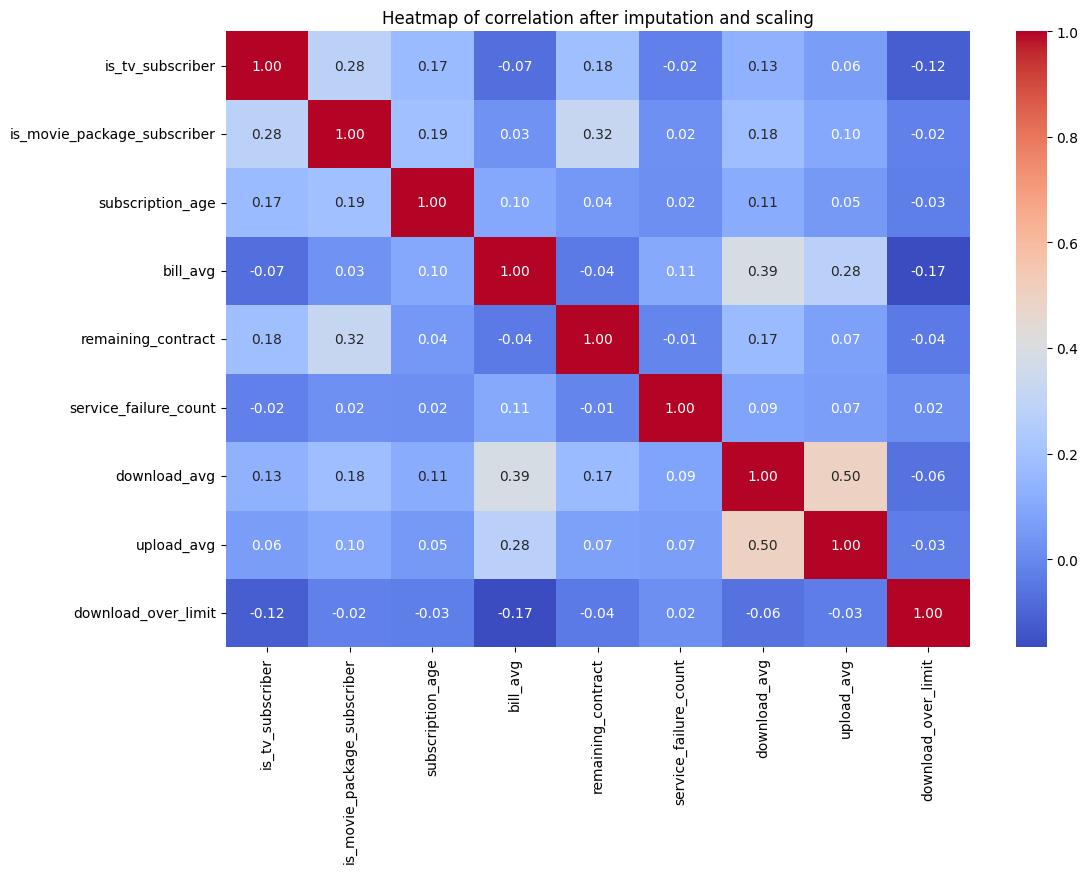

In [ ]:
corr_matrix = pd.DataFrame(X_train_clean_imputed, columns=X_train.columns).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of correlation after imputation and scaling')
plt.show()

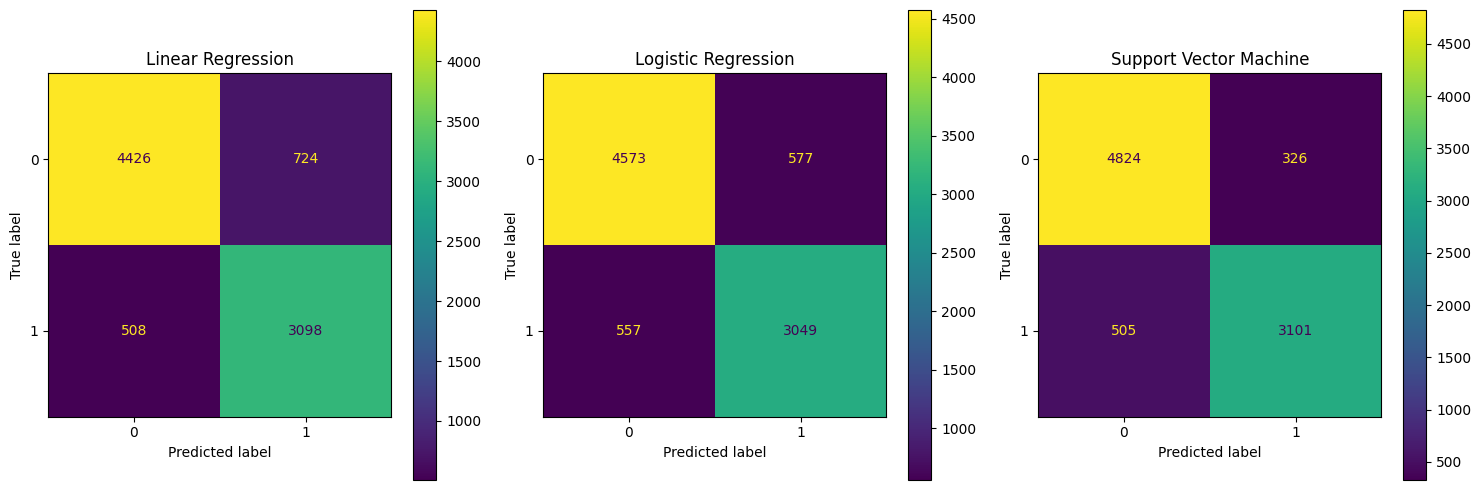

In [ ]:
cm_lr = confusion_matrix(y_test_clean, y_pred_lr_binary)
cm_log = confusion_matrix(y_test_clean, y_pred_log_binary)
cm_svm = confusion_matrix(y_test_clean, y_pred_svm_binary)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay(cm_lr, display_labels=[0, 1]).plot(ax=ax[0])
ax[0].set_title("Linear Regression")

ConfusionMatrixDisplay(cm_log, display_labels=[0, 1]).plot(ax=ax[1])
ax[1].set_title("Logistic Regression")

ConfusionMatrixDisplay(cm_svm, display_labels=[0, 1]).plot(ax=ax[2])
ax[2].set_title("Support Vector Machine")

plt.tight_layout()
plt.show()
